In [23]:
from langchain.schema import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda,RunnableParallel,RunnablePassthrough
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from typing import Annotated, Sequence, TypedDict
import os
import re
load_dotenv()
travly=os.getenv('travly')
os.environ["TAVILY_API_KEY"] = travly 

from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage
from langgraph.graph import StateGraph,END,START
from langchain.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages


api_key=os.getenv('groq_api')
llm=ChatGroq(model="llama-3.1-8b-instant",api_key=api_key)

In [2]:
embedings= HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

db = FAISS.load_local('my_faiss_index', embedings, allow_dangerous_deserialization=True)


/Users/sahilraj/Desktop/Agentic_ai/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
retriever = db.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 3, "lambda_mult": 0.5}
)

In [4]:
retriever.invoke('what is fever')

[Document(id='426152fd-4d8c-4336-bee8-fc648c68620e', metadata={}, page_content='What causes fever?Hello!I really appreciate your concern. There are certain possibilities about your fever. It may be due to untreated malaria if malaria is prevalent in your area. It may be due to bacterial sore throat which is relapsing when your immunity is down.If person come to my clinic with similar complaints I would advise him some blood test like complete blood count with malaria parasite testing. Further management depends upon it.Hope my answer has solved your query. Take Care.Thank you. Best Regards.Dr. Manan'),
 Document(id='7231e644-2161-426e-b350-0d4c572b6f98', metadata={}, page_content='What is brain fever?Hello,I had gone through your query and understand your concern. Short answer: Brain fever is infection of part of brain.Detailed answer: Thanks for asking on HCM.Brain fever is a term used to refer an infection of brain. It may encephalitis, meningitis, cerebritis etc. It may also be due 

In [5]:

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    "retriever_tool",
    "Information related to medical conditions, symptoms, treatments, medications, and health advice. Use this tool to answer specific questions about illnesses, drugs, and general health topics.",
)
search_tool = TavilySearchResults(max_results=2)
tools = [search_tool,retriever_tool]

/var/folders/wj/7vhzs5pd1070p45fjvwk8q480000gn/T/ipykernel_5320/2037232497.py:8: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=2)


In [17]:
# Define Agent State
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


In [24]:

# Agent Function
def agent(state: AgentState):
    """
    The agent's main function. It reasons and decides to act or provide a final answer.
    """
    messages = state['messages']
    tool_names = ", ".join([tool.name for tool in tools])
    tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in tools])

    prompt = f"""
    You are DoctorBot, a highly knowledgeable and empathetic AI medical assistant. 
    Your role is to provide accurate and helpful medical information and possible explanations, 
    but you are NOT a licensed doctor. 

    You have access to the following tools:
    {tool_descriptions}

    Your primary goals are:
    - Be empathetic and reassuring, maintaining a professional and warm tone.
    - Provide accurate and concise information based on your knowledge and tools.
    - Use the retriever tool to look up possible causes of symptoms whenever symptoms are mentioned.

    You MUST follow these rules:

    1. If the user reports symptoms (e.g., fever, headache, cough), always query the retriever tool first 
    to check for possible related conditions.
    2. When giving the Final Answer, clearly explain:
    - The common possible causes of those symptoms (from retriever/database).
    - General self-care measures (hydration, rest, monitoring).
    - A strong disclaimer that only a doctor can confirm the actual diagnosis.
    3. Never present a single definitive diagnosis. Always present information as "possible causes" or "conditions that are sometimes associated".
    4. Never prescribe medications, doses, or treatments. Instead, recommend consulting a licensed healthcare professional.
    5. If symptoms indicate an emergency (e.g., severe chest pain, difficulty breathing, unconsciousness), instruct the user to seek immediate emergency care.
    6. The Final Answer must be conversational, empathetic, and merged from all relevant tool outputs.

    Response format (strictly follow ReAct pattern):

    If reasoning:
    Thought: your reasoning about the request.
    Action: the tool you want to use, must be one of [{tool_names}]
    Action Input: input for that tool.

    If answering:
    Final Answer: A complete, empathetic, and conversational response with possible causes 
    (based on tool output), self-care tips, and a clear disclaimer that only a doctor can provide a real diagnosis.

    Conversation history:
    {messages}
    """
    response_content = llm.invoke(prompt).content
    return {'messages': [AIMessage(content=response_content)]}


In [ ]:
# Tool Calling Function
def call_tool(state: AgentState):
    """
    Parses the agent's action and calls the appropriate tool.
    """
    last_message = state['messages'][-1]
    
    action_match = re.search(r"Action:\s*([^\n]+)", last_message.content)
    action_input_match = re.search(r"Action Input:\s*([^\n]+)", last_message.content)

    if not action_match or not action_input_match:
        return {'messages': [ToolMessage(content="Error: Could not parse tool action from agent response.", tool_call_id="parse_error")]}

    tool_name = action_match.group(1).strip()
    tool_input = action_input_match.group(1).strip()

    tool_to_run = next((t for t in tools if t.name == tool_name), None)
    if tool_to_run:
        try:
            tool_output = tool_to_run.invoke(tool_input)
            return {'messages': [ToolMessage(content=tool_output, tool_call_id=tool_name)]} 
        except Exception as e:
            return {'messages': [ToolMessage(content=f"Error: Tool '{tool_name}' failed with: {str(e)}", tool_call_id=tool_name)]}
    else:
        return {'messages': [ToolMessage(content=f"Error: Unknown tool '{tool_name}'", tool_call_id="unknown_tool")]}

In [25]:
# Router Function
def should_continue(state: AgentState):
    """
    Router function to decide if the workflow should continue.
    """
    last_message = state['messages'][-1]
    
    if "Final Answer:" in last_message.content:
        return END
        
    if "Action:" in last_message.content and "Action Input:" in last_message.content:
        return "tools"
    
    # Fallback to END if neither a Final Answer nor an Action is found,
    # to prevent infinite loops if the LLM output is malformed.
    return END


In [26]:
from langgraph.checkpoint.memory import MemorySaver
checkpointer=MemorySaver()
graph=StateGraph(AgentState)

graph.add_node("agent",agent)
graph.add_node("tools",call_tool)

graph.add_edge(START,"agent")
graph.add_conditional_edges("agent",should_continue,{"tools":"tools",END:END})
graph.add_edge("tools","agent")
app=graph.compile(checkpointer=checkpointer)

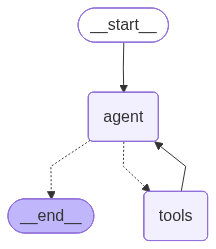

In [40]:
app

In [34]:
print(app.get_graph().draw_ascii())


        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
          +-------+           
          | agent |           
          +-------+.          
          .         .         
        ..           ..       
       .               .      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 


In [28]:
cnf={'configurable':{'thread_id':2}}
query="Hi my name is sahil raj"
app.invoke({"messages":HumanMessage(content=query)},config=cnf)

{'messages': [HumanMessage(content='Hi my name is sahil raj', additional_kwargs={}, response_metadata={}, id='f47644d4-f4e3-4fd6-9bdf-37a143f58d88'),
  AIMessage(content="Hello Sahil Raj! It's great to meet you. I'm DoctorBot, your friendly AI medical assistant. I'm here to help answer any health-related questions you may have, provide information, and offer guidance. Please feel free to share your concerns or questions, and I'll do my best to assist you.\n\nWhat's on your mind, Sahil?", additional_kwargs={}, response_metadata={}, id='418c7cdd-8e3c-4417-97ef-710c39b69058')]}

In [30]:
cnf={'configurable':{'thread_id':7}}
query="Symptoms of heart attack?"
result=app.invoke({"messages":HumanMessage(content=query)},config=cnf)

In [31]:
result['messages']

[HumanMessage(content='Symptoms of heart attack?', additional_kwargs={}, response_metadata={}, id='136d1829-b703-40a5-984f-8daa8ac3e141'),
 AIMessage(content="To address the user's concern about symptoms of a heart attack, I will first use the retriever tool to gather information on possible related conditions. \n\nIf reasoning:\nThought: I need to determine possible causes of a heart attack.\nAction: retriever_tool\nAction Input: symptoms of a heart attack\n\nPlease wait while I retrieve the information...", additional_kwargs={}, response_metadata={}, id='cd9fb084-24e9-4928-a3df-68d1a04a54de'),
 HumanMessage(content='Symptoms of heart attack?', additional_kwargs={}, response_metadata={}, id='78912ba0-5b06-4570-bcad-6b4714b4ea96'),
 AIMessage(content="To address the user's concern about symptoms of a heart attack, I will first use the retriever tool to gather information on possible related conditions.\n\nIf reasoning:\nThought: I need to determine possible causes of a heart attack.\nA

In [13]:
import re
query="Symptoms of blood cancer?"
cnf={'configurable':{'thread_id':10}}
for message_chunk,metatdata in app.stream({"messages": [HumanMessage(content=query)],"intermediate_steps":[HumanMessage(content=query)]},config=cnf,stream_mode='messages'):
    if message_chunk.content:
            print(message_chunk.content,end='',flush=True)


Thought: The user is asking about symptoms of blood cancer, so I should use the retriever tool to provide information about possible symptoms. 
Action: retriever_tool
Action Input: Symptoms of blood cancer 

Thought: The user is asking about symptoms of blood cancer, so I should use the retriever tool to provide information about possible symptoms. 
Action: retriever_tool
Action Input: Symptoms of blood cancer 

Tool Output: What are the symptoms of cancer?Hi and welcome to HCmyes but this is not the first thing to think of. this is more likely to be some systemic infection and this is the first thing to evaluate. blood disorders can furthetly be evaluated by hematologist but as I said you should be optimistic and do compelte work up.,, Wish you good health. Regards

My friend is suffering from blood cancer, please helpHi and welcome to healthcare magic forum. Blood cancer is a very broad terminology. There are many types of blood cancer and the survival rate will depend upon type and 